**STEP 1:** 

Import `seillra` and other packages:

In [1]:
import os, sys
import pandas as pd
import torch
import numpy as np
import collections

import seillra as sl

**STEP 2:**

- Decide on rank of approximate linear layers: 64
- Decide on the output type: chromatin profiles (d=231,907) or sequence classes (d=61)
- Decide on the device to use for inference (CPU)
- If infierence is on arm64 hardware (e.g. macbook), use `qnnpack` as backend if `quant == "CPU"`

Then load the according model.

In [2]:
import platform

# - what model to load
rank = 64
sequence_classes = False  # True
sequence_type = "sequence"  # "variant"
quant = "CPU"  # None, "GPU_fp16", "GPU_int8"

# - CPU quantization backend
if quant == "CPU":
    if platform.machine() == "arm64":
        if "qnnpack" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "qnnpack"
        else:
            raise RuntimeError("QNNPACK not supported on this arm64 machine.")
    if platform.machine() == "x86_64":
        if "fbgemm" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "fbgemm"
        else:
            raise RuntimeError("FBGEMM not supported on this x86_64 machine.")
    print("Using quantized engine:", torch.backends.quantized.engine)

# - load the model
model = sl.Sei_LLRA(
    k=rank, projection=sequence_classes, mode=sequence_type, quant=quant
)

Using quantized engine: fbgemm


2026-01-21 09:46:54,513 - INFO - Checksum verified for url_a6038b62128b5b01_wts: 28a1a49ca62e4d67a62c170df3751f7255db6eea3923455c119c762dde446308
2026-01-21 09:46:54,514 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_a6038b62128b5b01_wts
2026-01-21 09:46:54,757 - INFO - Model weights loaded and set to eval mode.
2026-01-21 09:46:54,962 - INFO - Checksum verified for url_b9a0eb4608886e0d_wts: e50fe852023657a60952698c591b291df0e4db3111a0e8ea122546f70eee27c3
2026-01-21 09:46:54,962 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_b9a0eb4608886e0d_wts
2026-01-21 09:46:55,055 - INFO - Model weights loaded and set to eval mode.


(See the readme file for loading the Sei model components (trunk, head, projection) seperately)

**STEP 3:**

Use the model to predict sequence classes (since we indlucded the projection model for DNA input sequences):

- Generate 16 random input sequences
- Apply the `seillra` model
- Print (part of) the result

In [29]:
# - random 1-hot sequences
sequences = torch.randint(0, 4, (16, 4096))
x = torch.nn.functional.one_hot(sequences, num_classes=4).permute(0, 2, 1).float()

# - run the model
out = model(x.to("cpu"))

# - typically discard the "unintersting" sequence classes (see the original Sei repository/paper)
res = out[:, :22]

# - Sequence class scores for the first 3 sequences and first 11 classes
print(res[:3, :11])

tensor([[2.4162e-05, 2.3348e-04, 3.9806e-05, 1.1663e-04, 5.6661e-05, 4.4921e-04,
         9.6679e-04, 1.9673e-05, 1.7488e-05, 8.2144e-06, 4.4224e-05],
        [2.3250e-03, 2.1100e-02, 2.0562e-02, 8.7872e-03, 6.4724e-03, 3.3809e-02,
         5.1524e-02, 1.2489e-03, 1.6647e-03, 1.2245e-03, 2.6522e-03],
        [2.7395e-04, 1.5169e-03, 1.0435e-03, 9.7964e-04, 7.0405e-04, 5.8683e-03,
         8.1769e-03, 1.7876e-04, 2.0584e-04, 1.1066e-04, 2.8452e-04]])


**STEP 4:**

Plot a heatmap with sequence class annotations.

Target annotations: (21907, 3):

                         context  assay     info
0         HeLa_Epithelium_Cervix  BTAF1     ID:1
1  H9_Embryonic_Stem_Cell_Embryo  EOMES  ID:1006
2  H9_Embryonic_Stem_Cell_Embryo  EP300  ID:1007
3  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1010
4  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1011
5  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1012
6  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1013


Text(0.5, 1.0, 'Heatmap for 16 sequences and first 22 chromatin features')

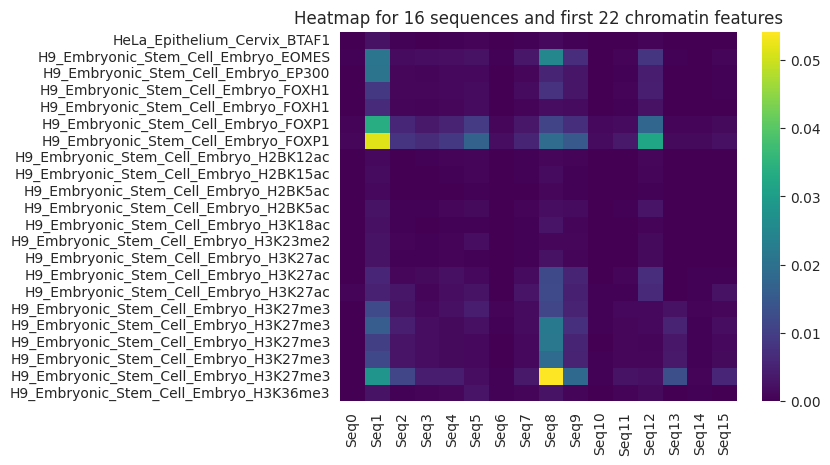

In [36]:
import pandas as pd

tgts = pd.DataFrame(model.head.target_annot)
print(f"Target annotations: {tgts.shape}:\n")
print(tgts.head(7))

# - make a heatmap of res for the first 55 seqs and 100 chromatin features
# - use sequences on the y-axis (and label accordingly)
# - use chromatin features on the x-axis (and label accordingly)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.heatmap(
    res.cpu().detach().numpy().T,
    yticklabels=tgts["context"][:22] + "_" + tgts["assay"][:22],
    xticklabels=[f"Seq{i}" for i in range(16)],
    cmap="viridis",
    vmin=0,
    vmax=res[:16, :22].max().item(),
)
plt.title("Heatmap for 16 sequences and first 22 chromatin features", fontsize=12)

In [22]:
res.shape

torch.Size([16, 40])